<a href="https://colab.research.google.com/github/SasikaA073/D2BGAN-m/blob/main/D2B_GAN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D2BGAN Paper Implementation

 Paper Title : **D2BGAN : A Dark to Bright Image Conversion Model for Quality Enhancement and Analysis Tasks Without Paired Supervision**

Implementation of this paper (D2BGAN) : https://ieeexplore.ieee.org/document/9784432

# Questions

### Q1. What's the difference between Batch normalization and Instance normalization?

Instance normalization and normalization are both techniques used in machine learning and deep learning, but they serve different purposes.

1. **Normalization (Batch Normalization)**:
   - Normalization, often referred to as batch normalization in the context of neural networks, is a technique used to normalize the inputs of each layer in a neural network.
   - Batch normalization normalizes the activations of each layer by subtracting the mean and dividing by the standard deviation of the mini-batch during training.
   - This helps in reducing the internal covariate shift problem, stabilizing and accelerating the training of deep neural networks.

2. **Instance Normalization**:
   - Instance normalization is a technique used in image processing and style transfer, particularly in tasks where the spatial information of the image is crucial.
   - Instead of normalizing across the batch dimension as in batch normalization, instance normalization normalizes across the spatial dimensions (typically height and width) of each individual sample.
   - Instance normalization is applied independently to each sample (or instance), disregarding the statistics of other samples in the batch.
   - It is often used to remove style information from images, helping to generalize better across different styles in tasks like image-to-image translation or style transfer.

In summary, batch normalization normalizes across the batch dimension in neural networks to improve training dynamics, while instance normalization normalizes across spatial dimensions within each sample, often used in image processing tasks.

### Q2. What are the available padding modes in nn.Conv2D?

In PyTorch's `nn.Conv2d` module, you can specify different padding modes using the `padding_mode` parameter. The available padding modes are:

1. **'zeros'**: This is the default padding mode. It pads the input with zeros.

2. **'reflect'**: It pads the input by reflecting the elements of the input along the edges.

3. **'replicate'**: It pads the input by replicating the last element along the edges.

These padding modes allow you to control how the input tensor is padded before applying convolution operations. Depending on the nature of your data and the specific requirements of your model, you can choose the appropriate padding mode to achieve the desired behavior.

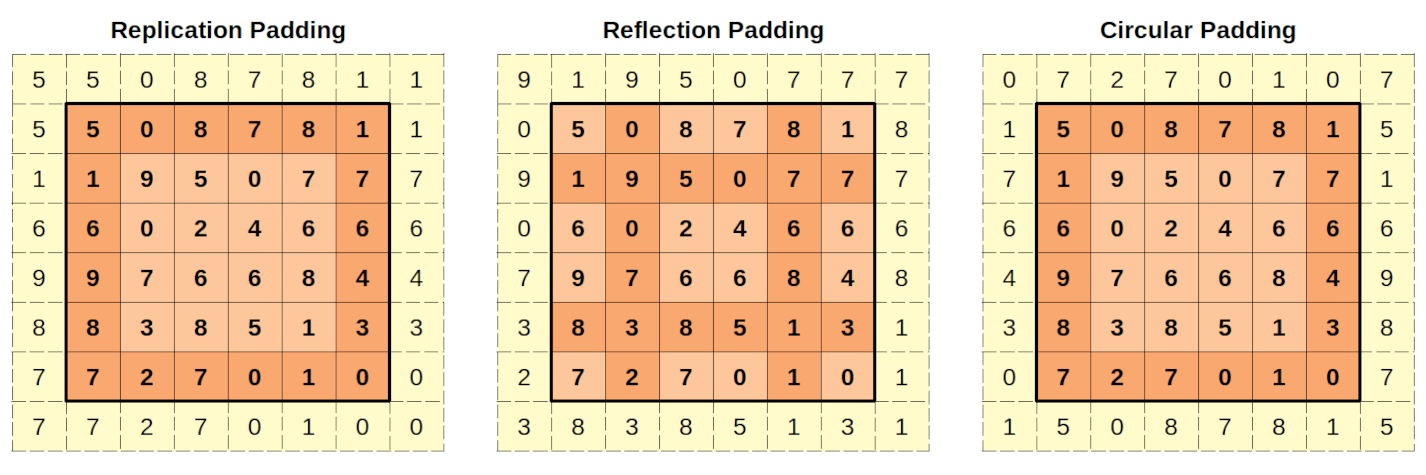

### Q3 : Why OpenCV uses BGR mode?

OpenCV (Open Source Computer Vision Library) uses BGR (Blue, Green, Red) color format as the default color space for images. There are historical and technical reasons behind this choice:

1. **Historical Reasons**:
   - OpenCV originated from Intel in the late 1990s. At that time, BGR color ordering was popular in Windows-based systems and with many camera and video codecs.
   - BGR ordering was also used by default in the popular image processing library at the time, Intel Image Processing Library (IPL), which served as one of the foundations for OpenCV.

2. **Compatibility**:
   - BGR ordering aligns well with how many camera sensors and image/video codecs output data natively.
   - It is also consistent with many other libraries and tools used alongside OpenCV, such as NumPy and Matplotlib.

3. **Efficiency**:
   - When OpenCV was initially developed, it was optimized for speed and efficiency. Using BGR ordering allowed for better performance in certain operations compared to RGB ordering due to memory layout considerations.

4. **Backward Compatibility**:
   - Switching to a different color ordering system could break existing code and cause compatibility issues with older applications and libraries that rely on OpenCV's BGR convention.

Despite these reasons, it's important to note that OpenCV provides functions to easily convert between BGR and other color spaces like RGB, HSV, etc., so users can work with the color space that best suits their needs.

# Architecture

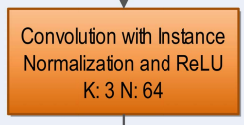

In [ ]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size, padding, stride, padding_mode="reflect", is_relu=True, down=True):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride, padding_mode=padding_mode),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if is_relu else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
def test_ConvBlock():
    images_per_batch = 5
    img_channels = 3
    img_size = 128
    x = torch.randn((images_per_batch, img_channels, img_size, img_size))
    gen = ConvBlock(in_channels=img_channels, out_channels=256, kernel_size=3,padding=1, stride=1, is_relu=True)
    print("input : ", x.shape)
    print("decoder of generator output : " , gen(x).shape)

test_ConvBlock()

input :  torch.Size([5, 3, 128, 128])
decoder of generator output :  torch.Size([5, 256, 128, 128])


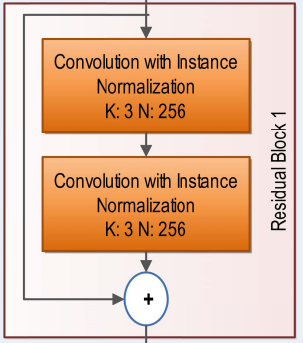

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels, padding_mode="reflect"): # Because of Residual block height, width or number of channels will not be changed.
    super().__init__()

    self.block = nn.Sequential(
        # There are two conv blocks in a residual block
        ConvBlock(in_channels=channels, out_channels=channels, kernel_size=3, padding=1, stride=1, is_relu=False, padding_mode=padding_mode),  # padding 1 , stride = 1 for no change in height and width
        ConvBlock(in_channels=channels, out_channels=channels, kernel_size=3, padding=1, stride=1, is_relu=False, padding_mode=padding_mode)
    )

  def forward(self, x):
    return x + self.block(x)

  def print_architecture(self):
    print(self)

  def debug_ResidualBlock(self,x):
    print("Input : ", x.shape)

    # Iterate through conv blocks
    for i, block in enumerate(self.block):
      print(i)
      for j, layer in enumerate(self.block[i].conv):
        print("\t\t",j, layer)

        x = layer(x)
        # print()
        print(x.shape)



def test_ResidualBlock():
    images_per_batch = 5
    img_channels = 3
    out_channels = 56
    img_size = 128
    x = torch.randn((images_per_batch, 256, img_size, img_size))
    gen = ResidualBlock(channels=256)
    # gen.print_architecture()
    gen.debug_ResidualBlock(x)
    # print("input : ", x.shape)
    # print("decoder of generator output : " , gen(x).shape)

# test_ResidualBlock()


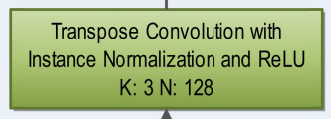

In [ ]:
class TransposeConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels,kernel_size,padding, stride, padding_mode="reflect", is_relu=True, down=True):
    super().__init__()

    self.transposeConv = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride, padding_mode=padding_mode),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace=True) if is_relu else nn.Identity()
    )

  def forward(self, x):
    return self.transposeConv(x)

## Encoder of Generator

In [ ]:
class GeneratorEncoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=64):
    super().__init__()

    self.encoder = nn.Sequential(
        ConvBlock(in_channels, out_channels, kernel_size=3, padding=1, stride=1, is_relu=True),
        ConvBlock(out_channels, out_channels*2, kernel_size=3, padding=1, stride=1, is_relu=True),
        ConvBlock(out_channels*2, out_channels*4, kernel_size=3, padding=1, stride=1, is_relu=True),

        ResidualBlock(out_channels*4),
        ResidualBlock(out_channels*4)
    )


  def forward(self, x):
    x = self.encoder(x)

    return x

In [ ]:
def test_generator_encoder():
    images_per_batch = 5
    img_channels = 3
    img_size = 128
    x = torch.randn((images_per_batch, img_channels, img_size, img_size))
    gen = GeneratorEncoder(in_channels=3,out_channels=64)
    print("input : ", x.shape)
    print("encoder of generator output : " , gen(x).shape)

# test_generator_encoder()

## Decoder of Generator

In [ ]:
class GeneratorDecoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=64):
    super().__init__()

    self.decoder = nn.Sequential(
        ResidualBlock(out_channels*4, padding_mode="zeros"),
        ResidualBlock(out_channels*4, padding_mode="zeros"),

        TransposeConvBlock(out_channels*4, out_channels*2,kernel_size=3,padding=1, stride=1, is_relu=True, padding_mode="zeros"),
        TransposeConvBlock(out_channels*2, out_channels,kernel_size=3,padding=1, stride=1, is_relu=True, padding_mode="zeros"),
        TransposeConvBlock(out_channels, out_channels=in_channels,kernel_size=3,padding=1, stride=1, is_relu=True, padding_mode="zeros"),

    )


  def forward(self, x):
    x = self.decoder(x)

    return x

In [ ]:
def test_generator_decoder():
    images_per_batch = 5
    img_channels = 3
    img_size = 128
    x = torch.randn((images_per_batch, 256, img_size, img_size))
    gen = GeneratorDecoder()
    print("input : ", x.shape)
    print("decoder of generator output : " , gen(x).shape)

# test_generator_decoder()

## Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels=3, out_channels=64):
    super().__init__()

    self.encoder = GeneratorEncoder(in_channels=in_channels, out_channels=out_channels)
    self.decoder = GeneratorDecoder(in_channels=in_channels, out_channels=out_channels)

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

  def debug(self,x):
    print("Input : " ,x.shape)
    x = self.encoder(x)
    print("After encoder : ", x.shape)
    x = self.decoder(x)
    print("After decoder : ", x.shape)

    return x


In [ ]:
def test_generator():
  images_per_batch = 5
  img_channels = 4
  img_size = 128
  num_features = 50  # num of features in the feature vector (number of channels in an image in the encoder output)

  x = torch.randn((images_per_batch, img_channels, img_size, img_size))
  gen = Generator(in_channels=img_channels, out_channels=num_features)
  output = gen(x)
  gen.debug(x)
  print("generator output :", output.shape)

# test_generator()

## Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()

    self.discriminator = nn.Sequential(
        ConvBlock(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1, stride=1, is_relu=True),
        ConvBlock(in_channels=64, out_channels=64*2, kernel_size=3, padding=1, stride=1, is_relu=True),
        ConvBlock(in_channels=64*2, out_channels=64*4, kernel_size=3, padding=1, stride=1, is_relu=True),
        ConvBlock(in_channels=64*4, out_channels=64*8, kernel_size=3, padding=1, stride=1, is_relu=True),

        ConvBlock(in_channels=64*8, out_channels=1, kernel_size=3, padding=1, stride=1, is_relu=True)

    )

  def forward(self,x):
    return self.discriminator(x)

  def debug(self,x):
    for i, layer in enumerate(self.discriminator):
      print(i)


In [ ]:
def test_discriminator():
    images_per_batch = 5
    img_channels = 3
    img_size = 128
    x = torch.randn((images_per_batch, img_channels, img_size, img_size))
    gen = Discriminator(in_channels=img_channels)
    print("input : ", x.shape)
    print("discriminator output : " , gen(x).shape)
    # gen.debug(x)

# test_discriminator()

# Loss Criterion

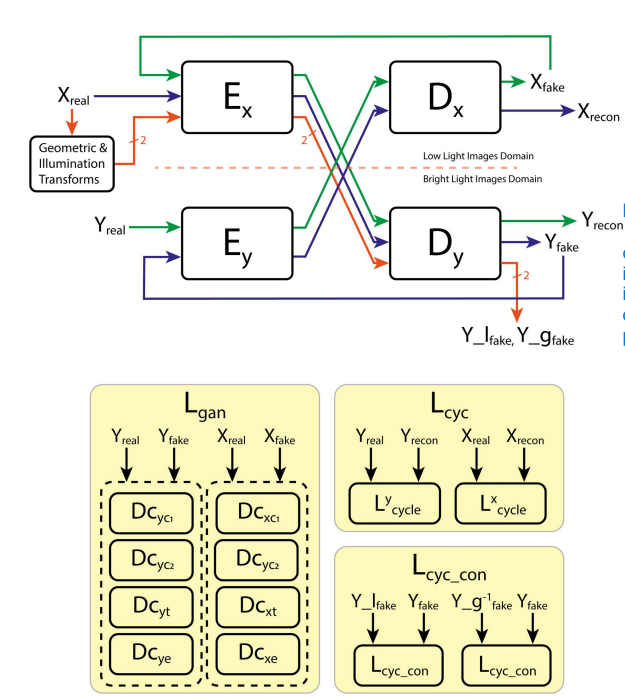

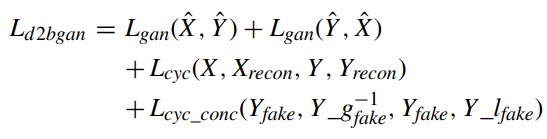

## General Adversarial Loss

## Cycle Reconstruction Loss

## Consistency Loss

### Geometry Loss

### Illumination Loss


# Configuration


In [ ]:
# Configuration setup from the CycleGAN paper

import torch, os
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# How they did in the D2BGAN paper
NUM_EPOCHS = 10
LEARNING_RATE = 0.0002
TRAIN_IMG_SIZE = 256

NUM_WORKERS = 4
BATCH_SIZE = 1


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_WORKERS = os.cpu_count()



TRAIN_DIR = "LOLdataset/our485/"
VAL_DIR = "LOLdataset/eval15/"

LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10




LOAD_MODEL = False
SAVE_MODEL = True

CHECKPOINT_GEN_DARK = "gen_dark.pth.tar"
CHECKPOINT_GEN_BRIGHT = "gen_bright.pth.tar"
CHECKPOINT_CRITIC_DARK = "critic_bright.pth.tar"
CHECKPOINT_CRITIC_BRIGHT = "critic_bright.pth.tar"


In [ ]:
print(DEVICE)
print(NUM_WORKERS)

cpu
2


In [ ]:
import torch
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.RandomCrop(size=TRAIN_IMG_SIZE),
    v2.ToTensor(),  # This will convert the PIL Image to a PyTorch tensor
    v2.ToDtype(torch.float32, scale=True), # Normalization expects float values
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# img = transforms(img)

# Utilites

In [ ]:
# # # prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
MODEL_PATH = "/models/"
OUTPUT_IMAGES_PATH = "/saved_images/"

In [ ]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr, device="cuda"):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location= device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Ensure Repeatability
seed_everything(42)

# Dataset

LOLDataset :

Adobe 5k Dataset : https://data.csail.mit.edu/graphics/fivek/ (47.3GB)
  

In [ ]:
# Download LOL dataset
!gdown --id 1E1rGvhzu0oWMuake4NBDbrKWZOVzDrFP

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1E1rGvhzu0oWMuake4NBDbrKWZOVzDrFP
From (redirected): https://drive.google.com/uc?id=1E1rGvhzu0oWMuake4NBDbrKWZOVzDrFP&confirm=t&uuid=dcc6a297-121d-4376-b1db-17567e776710
To: /content/LOLdataset.zip
100% 347M/347M [00:01<00:00, 181MB/s]


In [ ]:
# prompt: unzip "/content/LOLdataset.zip"

!unzip "/LOLdataset.zip" -d "/lol_dataset"


unzip:  cannot find or open /LOLdataset.zip, /LOLdataset.zip.zip or /LOLdataset.zip.ZIP.


In [ ]:
import torch
from PIL import Image
import os
# import config
import numpy as np
from torch.utils.data import Dataset, DataLoader

class LOLDataset(Dataset):
    def __init__(self, root_dark, root_bright, transform=train_transforms):
        super().__init__()

        self.root_dark = root_dark
        self.root_bright = root_bright
        self.transform = transform

        self.dark_images = os.listdir(root_dark)
        self.bright_images = os.listdir(root_bright)
        self.length_dataset = max(len(self.dark_images), len(self.bright_images))   # 485, 485 (I can add images as much as I want)
        self.dark_len = len(self.dark_images)
        self.bright_len = len(self.bright_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        dark_img = self.dark_images[index % self.dark_len]
        bright_img = self.bright_images[index % self.bright_len]

        dark_path = os.path.join(self.root_dark, dark_img)
        bright_path = os.path.join(self.root_bright, bright_img)

        # dark_img = np.array(Image.open(dark_path).convert("RGB"))
        # bright_img = np.array(Image.open(bright_path).convert("RGB"))

        dark_img = Image.open(dark_path).convert("RGB")
        bright_img = Image.open(bright_path).convert("RGB")

        if self.transform:
            dark_img = self.transform(dark_img)
            bright_img = self.transform(bright_img)
        return dark_img, bright_img


# Training


In [ ]:
import torch
import sys
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

## Treating as a pure CycleGAN

In [ ]:
import torch
import sys
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

def train_fn(disc_X, disc_Y, gen_X, gen_Y, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler, dataloader):
    # get a progress bar
    loop = tqdm(dataloader, leave=True)

    # x = dark, y = bright
    for idx, (X, Y) in enumerate(loop):
        # change the device of images
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        # Train Discriminators X and Y
        with torch.cuda.amp.autocast(): # to speed up training, dynamically autocast datatypes according to the context

            # DISCRIMINATOR X
            # generate dark image from bright image
            fake_X = gen_X(Y)

            # see whether dark discriminator can identify whether they are real or fake
            D_X_real = disc_X(X)
            D_X_fake = disc_X(fake_X.detach())

            # See how many times dark discriminator made incorrect predictions
            D_X_real_loss = mse(D_X_real, torch.ones_like(D_X_real)) # if real, target = 1
            D_X_fake_loss = mse(D_X_fake, torch.zeros_like(D_X_fake)) # if fake, target = 0

            D_X_loss = D_X_real_loss + D_X_fake_loss

            # DISCRIMINATOR Y
            # generate bright image from dark image
            fake_Y = gen_Y(X)

            # see whether bright discriminator can identify whether they are real or fake
            D_Y_real = disc_Y(Y)
            D_Y_fake = disc_Y(fake_Y.detach())

            # See how many times bright discriminator made incorrect predictions
            D_Y_real_loss = mse(D_Y_real, torch.ones_like(D_Y_real)) # if real, target = 1
            D_Y_fake_loss = mse(D_Y_fake, torch.zeros_like(D_Y_fake)) # if fake, target = 0
            D_Y_loss = D_Y_real_loss + D_Y_fake_loss

            # put it together
            D_loss = (D_X_loss + D_Y_loss)/2

        # Performs a training step for discriminators
        opt_disc.zero_grad() # clears the gradients of all optimized parameters of the discriminator
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators X and Y
        with torch.cuda.amp.autocast():
            D_X_fake = disc_X(fake_X)
            D_Y_fake = disc_Y(fake_Y)

            loss_G_X = mse(D_X_fake, torch.ones_like(D_X_fake))
            loss_G_Y = mse(D_Y_fake, torch.ones_like(D_Y_fake))

            # cycle loss
            # Generate dark image using fake bright image
            cycle_Y = gen_Y(fake_X)
            # Generate bright image using fake dark image
            cycle_X = gen_X(fake_Y)

            cycle_Y_loss = L1(Y, cycle_Y)
            cycle_X_loss = L1(X, cycle_X)

            # identity loss
            # Generate bright image using bright image
            identity_Y = gen_Y(Y)
            # Generate dark image using dark image
            identity_X = gen_X(X)

            identity_Y_loss = L1(Y, identity_Y)
            identity_X_loss = L1(X, identity_X)

            # add all together
            G_loss = (
                loss_G_X
                + loss_G_Y
                + cycle_X_loss * LAMBDA_CYCLE
                + cycle_X_loss * LAMBDA_CYCLE
                + identity_X_loss * LAMBDA_IDENTITY
                + identity_Y_loss * LAMBDA_IDENTITY
            )

        # Performs a training step for generators
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_X*0.5+0.5, f"saved_images/fake_dark_{idx}.png")
            save_image(fake_Y*0.5+0.5, f"saved_images/fake_bright_{idx}.png")

    return {
        "D_loss" : D_loss,
        "D_Y_real_loss": D_Y_real_loss,
        "D_Y_fake_loss": D_Y_fake_loss,
        "D_X_real_loss": D_X_real_loss,
        "D_X_fake_loss": D_X_real_loss,

        "G_loss": G_loss,
        "loss_G_X": loss_G_X,
        "loss_G_Y": loss_G_Y,
        "cycle_X_loss": cycle_X_loss,
        "cycle_X_loss": cycle_X_loss,
        "identity_X_loss": identity_X_loss,
        "identity_Y_loss": identity_Y_loss
    }

In [ ]:
dark_discriminator = Discriminator(in_channels=3).to(DEVICE)
bright_discriminator = Discriminator(in_channels=3).to(DEVICE)

dark_generator = Generator(in_channels=3, out_channels=64).to(DEVICE)
bright_generator = Generator(in_channels=3, out_channels=64).to(DEVICE)

opt_disc = optim.Adam(
    list(dark_discriminator.parameters()) + list(bright_discriminator.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999), # beta1 = 0.5, beta2 = 0.999 described as in the paper
)

opt_gen = optim.Adam(
    list(dark_generator.parameters()) + list(bright_generator.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999), # beta1 = 0.5, beta2 = 0.999 described as in the paper
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

In [ ]:

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN_DARK, dark_generator, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_GEN_BRIGHT, bright_generator, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_CRITIC_DARK, dark_discriminator, opt_disc, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_CRITIC_BRIGHT, bright_discriminator, opt_disc, LEARNING_RATE,
    )

dataset = LOLDataset(
    root_dark= TRAIN_DIR + "low",
    root_bright= TRAIN_DIR + "high",
    transform= train_transforms
)

dataloader = DataLoader(
    dataset,
    batch_size= BATCH_SIZE,
    # shuffle=True,
    shuffle=False,
    num_workers=NUM_WORKERS,  # what does this do?
    # pin_memory=True, # what does this do?
    pin_memory=False
)

generator_scale = torch.cuda.amp.GradScaler()
discriminator_scale = torch.cuda.amp.GradScaler()


FileNotFoundError: [Errno 2] No such file or directory: 'LOLdataset/our485/low'

In [ ]:
SAVE_EPOCH_FREQ = 2
SAVE_MODEL = True

In [ ]:
# train_fn(dark_discriminator, bright_discriminator, dark_generator, bright_generator, opt_disc, opt_gen, L1, mse, discriminator_scale, generator_scale, dataloader)


In [ ]:
times = 1
log_file_dir = "/"
log_file_path = log_file_dir + f"D2BGAN_as_CycleGAN_training_log_{times}.csv"

In [ ]:
import time

with open(log_file_path, "w") as log_file:
    first_line = "epoch,"
    first_line += "start_time,"
    first_line += "epoch_time,"
    first_line += "D_loss,"
    first_line += "D_X_real_loss,"
    first_line += "D_X_fake_loss,"
    first_line += "D_Y_real_loss,"
    first_line += "D_Y_fake_loss,"

    first_line += " G_loss,"
    first_line +=  " loss_G_X,"
    first_line += " loss_G_Y,"
    first_line += " cycle_X_loss,"
    first_line += " cycle_Y_loss,"
    first_line += " identity_X_loss,"
    first_line += " identity_Y_loss\n"
    log_file.write(first_line)


for epoch in range(NUM_EPOCHS):
    with open(log_file_path, "a") as log_file:

        epoch_start_time = time.time()  # Timer for entire epoch


        train_stats = train_fn(dark_discriminator, bright_discriminator, dark_generator, bright_generator, opt_disc, opt_gen, L1, mse, discriminator_scale, generator_scale, dataloader)

        if SAVE_MODEL and (epoch % SAVE_EPOCH_FREQ == 0):  # Fixed the condition
            save_checkpoint(dark_generator, opt_gen, filename=MODEL_PATH + CHECKPOINT_GEN_DARK)
            save_checkpoint(bright_generator, opt_gen, filename=MODEL_PATH + CHECKPOINT_GEN_BRIGHT)
            save_checkpoint(dark_discriminator, opt_disc, filename=MODEL_PATH + CHECKPOINT_CRITIC_DARK)
            save_checkpoint(bright_discriminator, opt_disc, filename=MODEL_PATH + CHECKPOINT_CRITIC_BRIGHT)

        epoch_time_taken = time.time() - epoch_start_time
        print(f"Epoch {epoch} / Time Taken: {epoch_time_taken:.2f} sec\n")

        log_message = str(epoch) + ","
        log_message += str(epoch_start_time) + ","
        log_message += str(epoch_time_taken) + ","

        log_message += str(train_stats["D_loss"]) + ","
        log_message += str(train_stats["D_X_real_loss"]) + ","
        log_message += str(train_stats["D_X_fake_loss"]) + ","
        log_message += str(train_stats["D_Y_real_loss"]) + ","
        log_message += str(train_stats["D_Y_fake_loss"]) + ","

        log_message += str(train_stats["G_loss"]) + ","
        log_message += str(train_stats["loss_G_X"]) + ","
        log_message += str(train_stats["loss_G_Y"]) + ","
        log_message += str(train_stats["cycle_X_loss"]) + ","
        log_message += str(train_stats["cycle_Y_loss"]) + ","
        log_message += str(train_stats["identity_X_loss"]) + ","
        log_message += str(train_stats["identity_Y_loss"]) + "\n"

        log_file.write(log_message)

        print(f"Epoch {epoch} / Time Taken: {epoch_time_taken:.2f} sec\n")




In [ ]:
import time

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time() # timer for entier epoch
    train_fn(dark_discriminator, bright_discriminator, dark_generator, bright_generator, opt_disc, opt_gen, L1, mse, discriminator_scale, generator_scale, dataloader)


    if SAVE_MODEL and (epoch % SAVE_EPOCH_FREQ):
        save_checkpoint(dark_generator, opt_gen, filename= MODEL_PATH + CHECKPOINT_GEN_DARK)
        save_checkpoint(bright_generator, opt_gen, filename= MODEL_PATH + CHECKPOINT_GEN_BRIGHT)
        save_checkpoint(dark_discriminator, opt_disc, filename=MODEL_PATH + CHECKPOINT_CRITIC_DARK)
        save_checkpoint(bright_discriminator, opt_disc, filename=MODEL_PATH + CHECKPOINT_CRITIC_BRIGHT)

    print(f"End of epoch {epoch} / Time Taken: {time.time() - epoch_start_time} sec")



## Treating for light-to-bright image domain

Required Transforms for Geometric and Illumination Consistency


In [ ]:
# Illumination consistency
import torch

class IlluminationTransform(object):
    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self, image):
        # Ensure the image is in the range [0, 1]
        image = torch.clamp(image, 0, 1)

        # Apply gamma transformation
        image = image ** self.gamma

        return image


In [ ]:
# For geometric consistency
import torch

class GeometricTransform(object):
    def __init__(self, k=1):
        self.k = k

    def __call__(self, image):
        # Rotate tensor by 90 degrees k times
        rotated_image = torch.rot90(image, self.k, (1, 2))

        return rotated_image

In [ ]:
import torch

class InverseGeometricTransform(object):
    def __init__(self, k=1):
        self.k = k

    def __call__(self, rotated_image):
        # Rotate tensor by -90 degrees k times to invert the rotation
        original_image = torch.rot90(rotated_image, -self.k, (1, 2))

        return original_image


_____ some experiment

In [ ]:
# 1. Color iamge using blurring
import torch
import torch.nn.functional as F

def gaussian_blur_tensor(image, kernel_size=3, sigma=1.0):
    # Convert image to float tensor
    image_tensor = image.float()

    # Define Gaussian kernel
    kernel = torch.tensor([[torch.exp(-((i - kernel_size // 2) ** 2 + (j - kernel_size // 2) ** 2) / (2 * sigma ** 2))
                            for j in range(kernel_size)] for i in range(kernel_size)])

    # Normalize kernel
    kernel = kernel / kernel.sum()

    # Add batch and channel dimensions
    kernel = kernel.unsqueeze(0).unsqueeze(0)

    # Apply convolution with Gaussian kernel
    blurred_image = F.conv2d(image_tensor.unsqueeze(0), kernel, padding=kernel_size // 2)

    return blurred_image.squeeze(0)


In [ ]:
# 3. Images

import torch
import torch.nn.functional as F

def prewitt_edge_detection_tensor(image):
    # Define Prewitt kernels
    kernel_x = torch.FloatTensor([[-1, 0, 1],
                                  [-1, 0, 1],
                                  [-1, 0, 1]]).unsqueeze(0).unsqueeze(0)

    kernel_y = torch.FloatTensor([[-1, -1, -1],
                                  [0, 0, 0],
                                  [1, 1, 1]]).unsqueeze(0).unsqueeze(0)

    # Convert image to float tensor and add batch dimension
    image_tensor = image.float().unsqueeze(0).unsqueeze(0)

    # Apply convolution with Prewitt kernels
    edge_x = F.conv2d(image_tensor, kernel_x, padding=1)
    edge_y = F.conv2d(image_tensor, kernel_y, padding=1)

    # Compute magnitude of gradients
    edge = torch.sqrt(edge_x**2 + edge_y**2)

    # Normalize values to 0-1 range
    edge = edge / edge.max()

    return edge.squeeze(0).squeeze(0)


In [ ]:
"""
Training for D2BGAN (Low Light Image Enhancement)

Programmed by Sasika Amarasinghe <sasikapamith2016@gmail.com>
* 2024-03-12: Initial coding
"""

import torch
import sys
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image


import torch
import sys
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

import config

from helper_transforms import IlluminationTransform, GeometricTransform, InverseGeometricTransform
from helper_transforms import gaussian_blur_tensor, get_grayscale_tensor, prewitt_edge_detection_tensor


def train_d2bgan(epoch, gen_X, gen_Y, disc_Xc1, disc_Xc2, disc_Xt, disc_Xe, disc_Yc1, disc_Yc2, disc_Yt, disc_Ye, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler, dataloader):
    # get a progress bar
    loop = tqdm(dataloader, leave=True)

    # x = dark, y = bright
    for idx, (X, Y) in enumerate(loop):
        # change the device of images
        X_real = X.to(config.DEVICE)
        Y_real = Y.to(config.DEVICE)

        # Train Discriminators X and Y
        with torch.cuda.amp.autocast(): # to speed up training, dynamically autocast datatypes according to the context

            # DISCRIMINATOR X


            # generate dark image from bright image
            X_fake = gen_X(Y_real)

            X_g_real = GeometricTransform(X_real)
            Y_g_fake = gen_Y(X_g_real)
            Y_g_fake_inverse = InverseGeometricTransform(Y_g_fake)

            # pass though illumination transformed X real image thorugh generator X
            X_i_real = IlluminationTransform(X_real)
            Y_i_fake = gen_Y(X_i_real)


            ####################################### see whether dark discriminator can identify whether they are real or fake
            # Dark discriminators
            # colors

            # 2 blur images
            Xc1_real = gaussian_blur_tensor(X_real, kernel_size = 3, sigma = config.BLUR_SIGMA_1)
            Xc1_fake = gaussian_blur_tensor(X_fake, kernel_size = 3, sigma = config.BLUR_SIGMA_1)

            Xc2_real = gaussian_blur_tensor(X_real, kernel_size = 3, sigma = config.BLUR_SIGMA_2)
            Xc2_fake = gaussian_blur_tensor(X_fake, kernel_size = 3, sigma = config.BLUR_SIGMA_2)

            D_Xc1_real = disc_Xc1(Xc1_real)
            D_Xc1_fake = disc_Xc1(Xc1_fake.detach())

            D_Xc2_real = disc_Xc2(Xc2_real)
            D_Xc2_fake = disc_Xc2(Xc2_fake.detach())

            # texture
            Xt_real = get_grayscale_tensor(X_real)
            Xt_fake = get_grayscale_tensor(X_fake)

            D_Xt_real = disc_Xt(Xt_real)
            D_Xt_fake = disc_Xt(Xt_fake.detach())

            #edge
            Xe_real = prewitt_edge_detection_tensor(X_real)
            Xe_fake = prewitt_edge_detection_tensor(X_fake)

            D_Xe_real = disc_Xe(Xe_real)
            D_Xe_fake = disc_Xt(Xe_fake.detach())

            # See how many times dark discriminator made incorrect predictions
            D_Xc1_real_loss = mse(D_Xc1_real, torch.ones_like(D_Xc1_real)) # if real, target = 1
            D_Xc1_fake_loss = mse(D_Xc1_fake, torch.zeros_like(D_Xc1_fake)) # if fake, target = 0

            D_Xc2_real_loss = mse(D_Xc2_real, torch.ones_like(D_Xc2_real)) # if real, target = 1
            D_Xc2_fake_loss = mse(D_Xc2_fake, torch.zeros_like(D_Xc2_fake))

            D_Xt_real_loss = mse(D_Xt_real, torch.ones_like(D_Xt_real)) # if real, target = 1
            D_Xt_fake_loss = mse(D_Xt_fake, torch.zeros_like(D_Xt_fake))

            D_Xe_real_loss = mse(D_Xe_real, torch.ones_like(D_Xe_real)) # if real, target = 1
            D_Xe_fake_loss = mse(D_Xe_fake, torch.zeros_like(D_Xe_fake))

            # put it together - I normalized this loss value
            L_gan_X_Y = (D_Xc1_real_loss + D_Xc1_fake_loss + D_Xc2_real_loss + D_Xc2_fake_loss + D_Xt_real_loss + D_Xt_fake_loss + D_Xe_real_loss + D_Xe_fake_loss)/8
            ###########################################

            # DISCRIMINATOR Y
            # generate bright image from dark image
            Y_fake = gen_Y(X_real)

            # pass through geometric transformed X real through generator X
            X_g_real = GeometricTransform(X_real)
            Y_g_fake = gen_Y(X_g_real)
            Y_g_fake_inverse = InverseGeometricTransform(Y_g_fake)

            # pass though illumination transformed X real image thorugh generator X
            X_i_real = IlluminationTransform(X_real)
            Y_i_fake = gen_Y(X_i_real)

            #############################################################
            # see whether bright discriminator can identify whether they are real or fake

            # Here instead of one discriminator, they have used 3 discriminators for color, texture, edge
            # colors
            Yc1_real = gaussian_blur_tensor(Y_real, kernel_size = 3, sigma = config.BLUR_SIGMA_1)
            Yc1_fake = gaussian_blur_tensor(Y_fake, kernel_size = 3, sigma = config.BLUR_SIGMA_1)

            Yc2_real = gaussian_blur_tensor(Y_real, kernel_size = 3, sigma = config.BLUR_SIGMA_2)
            Yc2_fake = gaussian_blur_tensor(Y_fake, kernel_size = 3, sigma = config.BLUR_SIGMA_2)


            D_Yc1_real = disc_Yc1(Yc1_real)
            D_Yc1_fake = disc_Yc1(Yc1_fake.detach())

            D_Yc2_real = disc_Yc2(Yc2_real)
            D_Yc2_fake = disc_Yc2(Yc2_fake.detach())

            # texture
            Yt_real = get_grayscale_tensor(Y_real)
            Yt_fake = get_grayscale_tensor(Y_fake)

            D_Yt_real = disc_Yt(Yt_real)
            D_Yt_fake = disc_Yt(Yt_fake.detach())

            # edge
            Ye_real = prewitt_edge_detection_tensor(Y_real)
            Ye_fake = prewitt_edge_detection_tensor(Y_fake)

            D_Ye_real = disc_Ye(Ye_real)
            D_Ye_fake = disc_Ye(Ye_fake.detach())

            # See how many times bright discriminator made incorrect predictions
            D_Yc1_real_loss = mse(D_Yc1_real, torch.ones_like(D_Yc1_real)) # if real, target = 1
            D_Yc1_fake_loss = mse(D_Yc1_fake, torch.zeros_like(D_Yc1_fake)) # if fake, target = 0

            D_Yc2_real_loss = mse(D_Yc2_real, torch.ones_like(D_Yc2_real)) # if real, target = 1
            D_Yc2_fake_loss = mse(D_Yc2_fake, torch.zeros_like(D_Yc2_fake))

            D_Yt_real_loss = mse(D_Yt_real, torch.ones_like(D_Yt_real)) # if real, target = 1
            D_Yt_fake_loss = mse(D_Yt_fake, torch.zeros_like(D_Yt_fake))

            D_Ye_real_loss = mse(D_Ye_real, torch.ones_like(D_Ye_real)) # if real, target = 1
            D_Ye_fake_loss = mse(D_Ye_fake, torch.zeros_like(D_Ye_fake))

            # put it together - I normalized this loss value
            L_gan_Y_X = (D_Yc1_real_loss + D_Yc1_fake_loss + D_Yc2_real_loss + D_Yc2_fake_loss + D_Yt_real_loss + D_Yt_fake_loss + D_Ye_real_loss + D_Ye_fake_loss)/8
            #############################################################

            # put it together
            L_gan_total = (L_gan_X_Y + L_gan_Y_X)/2

            D_loss = L_gan_total




        # Performs a training step for discriminators
        opt_disc.zero_grad() # clears the gradients of all optimized parameters of the discriminator
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators X and Y
        with torch.cuda.amp.autocast():
            ##################################################################
            # Generate dark image using fake bright image
            X_recon = gen_X(Y_fake)

            # Generate bright image using fake dark image
            Y_recon = gen_Y(X_fake)


            cycle_Y_loss = L1(Y_real, Y_recon)
            cycle_X_loss = L1(X_real, X_recon)

            # Cycle Reconstruction Loss
            L_cyc = (cycle_Y_loss + cycle_X_loss)/2

            L_d2b_base = (L_gan_total + L_cyc)/2

            # Cyclic Consistency Loss
            L_cyc_con = (L1(Y_fake, Y_g_fake_inverse) + L1(Y_fake, Y_i_fake))/2

            L_d2bgan = (L_d2b_base + L_cyc_con)/2

            # add all together
            G_loss = L_d2bgan

        # Performs a training step for generators
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0 and epoch % 10 == 0:
            save_image(X_real*0.5+0.5, f"saved_images/real_dark_{epoch}_{idx}.png")
            save_image(Y_real*0.5+0.5, f"saved_images/real_bright_{epoch}_{idx}.png")
            save_image(X_fake*0.5+0.5, f"saved_images/fake_dark_{epoch}_{idx}.png")
            save_image(Y_fake*0.5+0.5, f"saved_images/fake_bright_{epoch}_{idx}.png")



In [ ]:
dark_c1_discriminator = Discriminator(in_channels=3).to(DEVICE)
dark_c2_discriminator = Discriminator(in_channels=3).to(DEVICE)  # how to differentiate the following 4???
dark_t_discriminator = Discriminator(in_channels=3).to(DEVICE)
dark_e_discriminator = Discriminator(in_channels=3).to(DEVICE)

bright_c1_discriminator = Discriminator(in_channels=3).to(DEVICE)
bright_c2_discriminator = Discriminator(in_channels=3).to(DEVICE)  # how to differentiate the following 4???
bright_t_discriminator = Discriminator(in_channels=3).to(DEVICE)
bright_e_discriminator = Discriminator(in_channels=3).to(DEVICE)

#########################################################

dark_generator = Generator(in_channels=3, out_channels=64).to(DEVICE)
bright_generator = Generator(in_channels=3, out_channels=64).to(DEVICE)

opt_disc = optim.Adam(
    list(dark_discriminator.parameters()) + list(bright_discriminator.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999), # beta1 = 0.5, beta2 = 0.999 described as in the paper
)

opt_gen = optim.Adam(
    list(dark_generator.parameters()) + list(bright_generator.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999), # beta1 = 0.5, beta2 = 0.999 described as in the paper
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

In [ ]:

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN_DARK, dark_generator, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_GEN_BRIGHT, bright_generator, opt_gen, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_CRITIC_DARK, dark_discriminator, opt_disc, LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_CRITIC_BRIGHT, bright_discriminator, opt_disc, LEARNING_RATE,
    )

dataset = LOLDataset(
    root_dark= TRAIN_DIR + "low",
    root_bright= TRAIN_DIR + "high",
    transform= train_transforms
)

dataloader = DataLoader(
    dataset,
    batch_size= BATCH_SIZE,
    # shuffle=True,
    shuffle=False,
    num_workers=NUM_WORKERS,  # what does this do?
    # pin_memory=True, # what does this do?
    pin_memory=False
)

generator_scale = torch.cuda.amp.GradScaler()
discriminator_scale = torch.cuda.amp.GradScaler()


In [ ]:
train_stats = train_fn_2(dark_discriminator,
                               bright_discriminator, dark_generator, bright_generator, opt_disc, opt_gen, L1, mse, discriminator_scale, generator_scale, dataloader)


In [ ]:
import time

with open(log_file_path, "w") as log_file:
    first_line = "epoch,"
    first_line += "start_time,"
    first_line += "epoch_time,"
    first_line += "D_loss,"
    first_line += "D_X_real_loss,"
    first_line += "D_X_fake_loss,"
    first_line += "D_Y_real_loss,"
    first_line += "D_Y_fake_loss,"

    first_line += " G_loss,"
    first_line +=  " loss_G_X,"
    first_line += " loss_G_Y,"
    first_line += " cycle_X_loss,"
    first_line += " cycle_Y_loss,"
    first_line += " identity_X_loss,"
    first_line += " identity_Y_loss\n"
    log_file.write(first_line)


for epoch in range(NUM_EPOCHS):
    with open(log_file_path, "a") as log_file:

        epoch_start_time = time.time()  # Timer for entire epoch


        train_stats = train_fn(dark_discriminator,
                               bright_discriminator, dark_generator, bright_generator, opt_disc, opt_gen, L1, mse, discriminator_scale, generator_scale, dataloader)

        if SAVE_MODEL and (epoch % SAVE_EPOCH_FREQ == 0):  # Fixed the condition
            save_checkpoint(dark_generator, opt_gen, filename=MODEL_PATH + CHECKPOINT_GEN_DARK)
            save_checkpoint(bright_generator, opt_gen, filename=MODEL_PATH + CHECKPOINT_GEN_BRIGHT)
            save_checkpoint(dark_discriminator, opt_disc, filename=MODEL_PATH + CHECKPOINT_CRITIC_DARK)
            save_checkpoint(bright_discriminator, opt_disc, filename=MODEL_PATH + CHECKPOINT_CRITIC_BRIGHT)

        epoch_time_taken = time.time() - epoch_start_time
        print(f"Epoch {epoch} / Time Taken: {epoch_time_taken:.2f} sec\n")

        log_message = str(epoch) + ","
        log_message += str(epoch_start_time) + ","
        log_message += str(epoch_time_taken) + ","

        log_message += str(train_stats["D_loss"]) + ","
        log_message += str(train_stats["D_X_real_loss"]) + ","
        log_message += str(train_stats["D_X_fake_loss"]) + ","
        log_message += str(train_stats["D_Y_real_loss"]) + ","
        log_message += str(train_stats["D_Y_fake_loss"]) + ","

        log_message += str(train_stats["G_loss"]) + ","
        log_message += str(train_stats["loss_G_X"]) + ","
        log_message += str(train_stats["loss_G_Y"]) + ","
        log_message += str(train_stats["cycle_X_loss"]) + ","
        log_message += str(train_stats["cycle_Y_loss"]) + ","
        log_message += str(train_stats["identity_X_loss"]) + ","
        log_message += str(train_stats["identity_Y_loss"]) + "\n"

        log_file.write(log_message)

        print(f"Epoch {epoch} / Time Taken: {epoch_time_taken:.2f} sec\n")


